In [22]:
import pandas as pd
import numpy as np
import os
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.optimizers import Adam,Adamax,Nadam,Adadelta,SGD,RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.io_utils import HDF5Matrix
import h5py

from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import train_test_split

import cv2
import shapely.wkt
import shapely.affinity
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from shapely.wkt import loads as wkt_loads
import tifffile as tiff

In [23]:
train_wkt = pd.read_csv('train_wkt_v4.csv')
grid_size = pd.read_csv('grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
#submission = pd.read_csv(sample_submission.csv')
Image_ID = sorted(train_wkt.ImageId.unique())
ClassName = ['Building','Misc','Road','Track','Trees','Crops','Waterway','Standing water',' Vehicle Large','Vehicle Small']

In [24]:
N_split = 15
Patch_size = 224
Class_Type = 3

In [25]:
def Get_Image_band(image_id,image_band):
    if image_band =='RGB':
        filename = os.path.join('three_band', '{}.tif'.format(image_id))
    else:
        filename = os.path.join('sixteen_band', '{}_{}.tif'.format(image_id,image_band))
    img = tiff.imread(filename)
    if image_band == 'P':
        img = img[:,:,None]
    else:
        img = np.rollaxis(img, 0, 3)
    # divide every channel to its maximum possible value: 2048 for RGB,M,P, 16384 for A
    if image_band == 'A':
        img = img.astype(np.float32)/16384
    else:
        img = img.astype(np.float32)/2048    
    return img
# Resize and Join images of all 20 bands
def Get_Image_Allband(image_id, Scale_Size = Patch_size*N_split):
    img_RGB = cv2.resize(Get_Image_band(image_id,'RGB'),(Scale_Size,Scale_Size))    
    img_M = cv2.resize(Get_Image_band(image_id,'M'),(Scale_Size,Scale_Size))
    img_A = cv2.resize(Get_Image_band(image_id,'A'),(Scale_Size,Scale_Size))
    img_P = cv2.resize(Get_Image_band(image_id,'P'),(Scale_Size,Scale_Size))
    img = np.concatenate((img_RGB,img_M,img_A,img_P[:,:,None]), axis=2)
    return img

# Plot all 20 bands of an image
def Plot_Image_Allband(image_id):  
    img = Get_Image_Allband(image_id)
    plt.figure(figsize=[15,12])
    name_list = ['R','G','B']
    for i in range(1,9):
        name_list.append('M_{}'.format(i))
    for i in range(1,9):
        name_list.append('A_{}'.format(i))
    name_list.append('P')
    for i in range(1,21):
        plt.subplot(4,5,i)
        plt.imshow(img[:, :, i-1],cmap=plt.get_cmap('gist_ncar'))
        plt.title(name_list[i-1])
        plt.axis('off')
    plt.show()

In [5]:
#len(x)

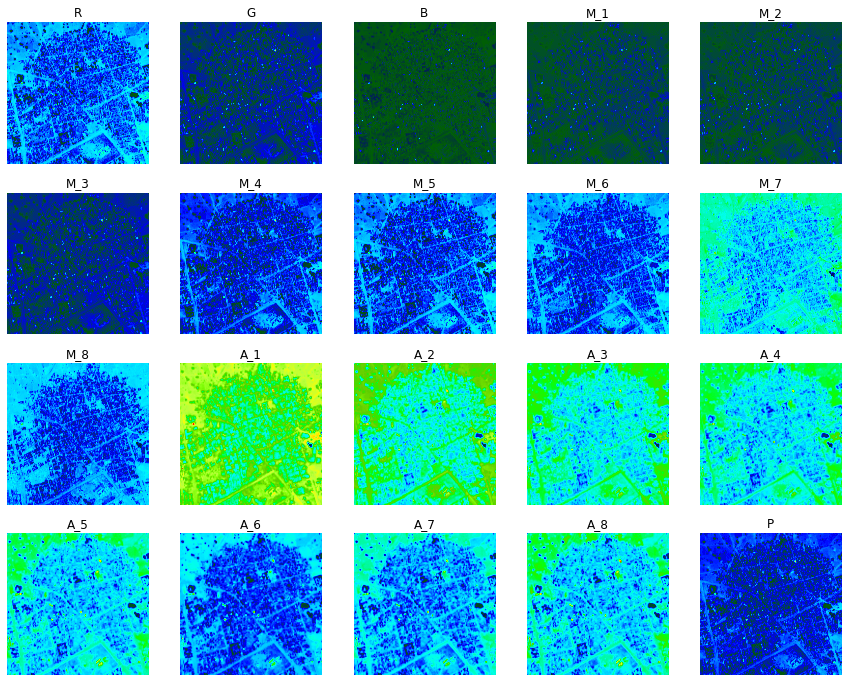

In [26]:
Plot_Image_Allband(Image_ID[17])

In [27]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)

def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList

def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list

def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=grid_size, wkt_list_pandas=train_wkt):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)
    mask = _plot_mask_from_contours(raster_size, contours, 1)
    return mask
def Plot_Mask_Allband(image_id):  
    img = Get_Image_Allband(image_id)
    plt.figure(figsize=[15,6])
    for i in range(1,11):
        plt.subplot(2,5,i)
        mask = generate_mask_for_image_and_class((img.shape[0], img.shape[1]),image_id, i)
        plt.imshow(mask[:, :],cmap=plt.get_cmap('gist_ncar'))
        plt.title(ClassName[i-1])
        plt.axis('off')
    plt.show()

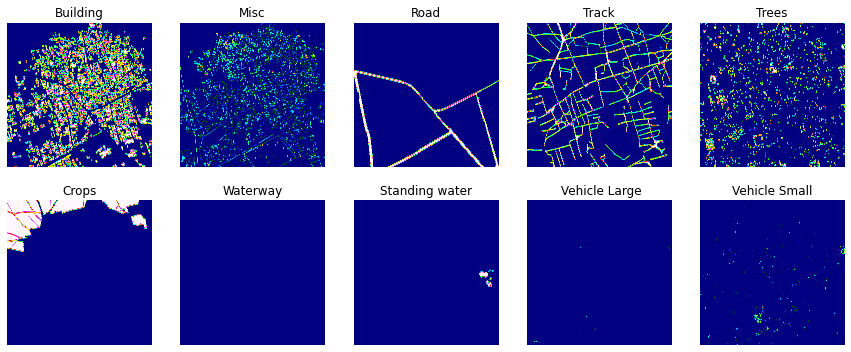

In [28]:
Plot_Mask_Allband(Image_ID[17])

In [29]:
def get_patch(img_id,pos = 1):
    N_patch = N_split**2
    x_all = []
    img = Get_Image_Allband(img_id)
    mask = generate_mask_for_image_and_class((img.shape[0], img.shape[1]),img_id, Class_Type)
    for i in range(N_split):
        for j in range(N_split):   
            y = mask[Patch_size*i:Patch_size*(i + 1), Patch_size*j:Patch_size*(j + 1)]
            if ((pos == 1) and (np.sum(y) > 0)) or (pos == 0) :
                x = img[Patch_size*i:Patch_size*(i + 1), Patch_size*j:Patch_size*(j + 1),:]
                x_all.append(np.concatenate((x,y[:,:,None]),axis = 2))
    x_all = np.asarray(x_all)
    return x_all
def get_all_patches(pos = 1):
    x = []
    count = 0
    for img_id in Image_ID:
        x_all = get_patch(img_id,pos = pos)
#         print ([img_id,len(x_all)])
        if len(x_all) > 0:
            count = count + 1
            if count == 1: 
                x = x_all
            else:
                x = np.concatenate((x,x_all),axis = 0)
    if pos == 1:
        np.save('data_pos_%d_%d_class%d' % (Patch_size, N_split, Class_Type), x)
    else:
        np.save('data_%d_%d_class%d' % (Patch_size, N_split, Class_Type), x)
    print (x.shape)
#     return x

In [30]:
get_all_patches()

(387, 224, 224, 21)


In [31]:
def get_normalized_patches():
    #data = get_all_patches()
    data = np.load('data_pos_%d_%d_class%d.npy' % (Patch_size, N_split, Class_Type))
    #print (data)
    img = data[:,:,:,:20]
    msk = data[:,:,:,20]
    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean)/std
    print (mean,std)
    print (np.mean(img),np.std(img))
    return img,msk

In [32]:
#data = np.load('data_pos_%d_%d_class%d.npy' % (Patch_size, N_split, Class_Type))
img,msk = get_normalized_patches()
#data

0.2364173 0.10123541
-5.9466556e-06 0.99999785


In [33]:
def post_normalize_image(img, mean=0.229798,std =0.097015):
    img = (img - mean)/std
    return img

In [34]:
def get_unet_5():
#     Patch_size = 224
    inputs = Input((Patch_size, Patch_size, 20))

    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
   
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4, up6], axis = 3)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    
    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [35]:
x_trn, x_val, y_trn, y_val = train_test_split(img, msk,test_size=0.2, random_state=42)
y_trn = y_trn[:,:,:,None]
y_val = y_val[:,:,:,None]
model = get_unet_5()
model_checkpoint = ModelCheckpoint('unet5_c1_{epoch:02d}.hdf5')
model.fit(x_trn, y_trn, batch_size=16, epochs=100, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_data=(x_val, y_val))

Train on 309 samples, validate on 78 samples
Epoch 1/100
309/309 [==============================] - 21s 69ms/step - loss: 0.7065 - accuracy: 0.8809 - val_loss: 0.3457 - val_accuracy: 0.8857
Epoch 2/100
309/309 [==============================] - 9s 30ms/step - loss: 0.2600 - accuracy: 0.8984 - val_loss: 0.2474 - val_accuracy: 0.9038
Epoch 3/100
309/309 [==============================] - 10s 31ms/step - loss: 0.2546 - accuracy: 0.9092 - val_loss: 0.2524 - val_accuracy: 0.9038
Epoch 4/100
309/309 [==============================] - 10s 31ms/step - loss: 0.2327 - accuracy: 0.9102 - val_loss: 0.2373 - val_accuracy: 0.9055
Epoch 5/100
309/309 [==============================] - 10s 31ms/step - loss: 0.2180 - accuracy: 0.9162 - val_loss: 0.2382 - val_accuracy: 0.9029
Epoch 6/100
309/309 [==============================] - 10s 31ms/step - loss: 0.2143 - accuracy: 0.9138 - val_loss: 0.2224 - val_accuracy: 0.9095
Epoch 7/100
309/309 [==============================] - 9s 31ms/step - loss: 0.2055 - a

# Model Evaluation

In [42]:
def calc_jacc(model,img,msk):
    msk = msk[:,:,:,None]
    prd = model.predict(img, batch_size=4)
    print (prd.shape, msk.shape)
    msk = msk.reshape(msk.shape[0]*msk.shape[1],msk.shape[2])
    prd = prd.reshape(prd.shape[0]*prd.shape[1],prd.shape[2])
    # loop over threshold to find the one with highest score
    score = 0
    scores = []
    for j in range(10):
        th = j / 10.0
        pred_binary_mask = prd > th
        jk = jaccard_similarity_score(msk, pred_binary_mask)
        scores.append(jk)
        if jk > score:
            score = jk
            best_th = th
    print('Jaccord Index :{0:.8f}'.format(score))
    print('Best Threshold :{0:.1f}'.format(best_th))
    return score, best_th

def calc_jacc_th(model,img,msk,th):
    msk = msk[:,:,:,None]
    prd = model.predict(img, batch_size=4)
    print (prd.shape, msk.shape)
    msk = msk.reshape(msk.shape[0]*msk.shape[1],msk.shape[2])
    prd = prd.reshape(prd.shape[0]*prd.shape[1],prd.shape[2])
    pred_binary_mask = prd > th
    score = jaccard_similarity_score(msk, pred_binary_mask)
    print('Jaccord Index with threshold {0:.1f} :{1:.8f}'.format(th,score))
    return score

In [43]:
def predict_id(img_id, model, th):
    img = Get_Image_Allband(img_id)
    img = post_normalize_image(img)
    
    prd = np.zeros((Patch_size*N_split, Patch_size*N_split,1)).astype(np.float32)

    for i in range(N_split):
        for j in range(N_split):   
            x = img[Patch_size*i:Patch_size*(i + 1), Patch_size*j:Patch_size*(j + 1),:]
            tmp = model.predict(x[None,:,:,:],batch_size = 4)
            prd[Patch_size*i:Patch_size*(i + 1), Patch_size*j:Patch_size*(j + 1)] = tmp
    prd = prd > th       
    return prd

def check_predict(model,th,img_id=Image_ID[17],Class_Type = 3):  
    msk_prd = predict_id(img_id, model, th)
    msk_prd = msk_prd[:,:,0]
    img = Get_Image_Allband(img_id)
    msk = generate_mask_for_image_and_class((img.shape[0], img.shape[1]),img_id, Class_Type)
    print(msk.shape)
    
    plt.figure(figsize=[14,8])
    plt.subplot(1,2,1)
    plt.title('Training Mask')
    plt.imshow(msk,cmap=plt.get_cmap('gist_ncar'))
    plt.subplot(1,2,2)
    plt.title('Predicted Mask')
    plt.imshow(msk_prd,cmap=plt.get_cmap('gist_ncar'))
    plt.axis('off')
    plt.show()

(3360, 3360)


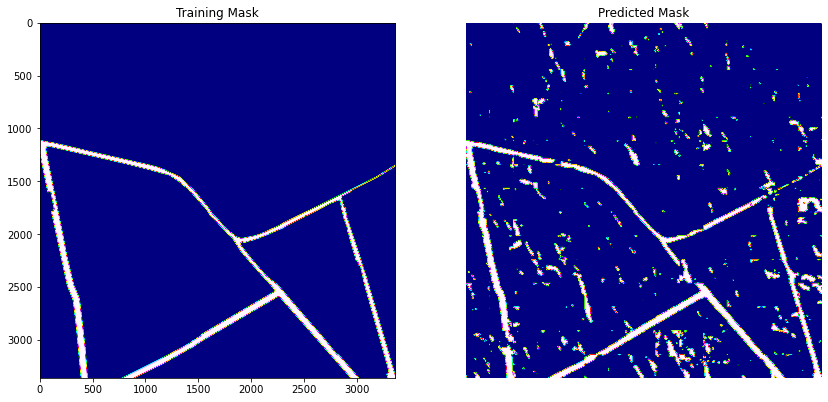

In [44]:
model = get_unet_5()  
model.load_weights('unet5_c1_96.hdf5')
check_predict(model,0.5)

In [45]:
img,msk = get_normalized_patches()

0.2364173 0.10123541
-5.9466556e-06 0.99999785


In [46]:
def predict_id_mask(img_id, model, th, img):
    img = img[img_id]
    img = post_normalize_image(img)
    
    
    prd = np.zeros((Patch_size*N_split, Patch_size*N_split,1)).astype(np.float32)

    for i in range(N_split):
        for j in range(N_split):   
            #x = img[Patch_size*i:Patch_size*(i + 1), Patch_size*j:Patch_size*(j + 1),:]
            x = img
            tmp = model.predict(x[None,:,:,:],batch_size = 4)
            prd[Patch_size*i:Patch_size*(i + 1), Patch_size*j:Patch_size*(j + 1)] = tmp
    prd = prd > th       
    return prd

def check_predict_mask(model,th,img_id=21,Class_Type = 3): 
    img,msk = get_normalized_patches()
    msk_prd = predict_id_mask(img_id, model, th, img)
    #print(msk_prd.shape)
    msk_prd = msk_prd[:224,:224,0]
    #print(msk_prd.shape)
    
    
    img = img[img_id]
    msk = msk[img_id]
    #print(msk.shape)
    
    print("Jaccard:",jaccard_similarity_score(msk, msk_prd))
    
    plt.figure(figsize=[14,8])
    plt.subplot(1,2,1)
    plt.title('Training Mask')
    plt.imshow(msk,cmap=plt.get_cmap('gist_ncar'))
    plt.subplot(1,2,2)
    plt.title('Predicted Mask')
    plt.imshow(msk_prd,cmap=plt.get_cmap('gist_ncar'))
    plt.axis('off')
    plt.show()

0.2364173 0.10123541
-5.9466556e-06 0.99999785
Jaccard: 0.7891088124111819


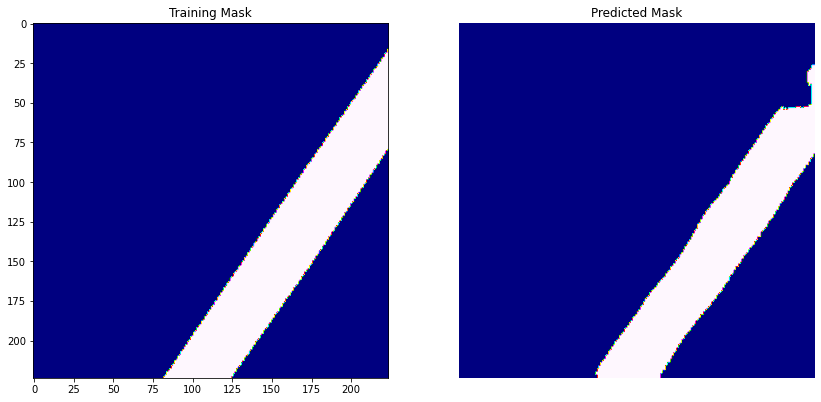

0.2364173 0.10123541
-5.9466556e-06 0.99999785
Jaccard: 0.4107142857142857


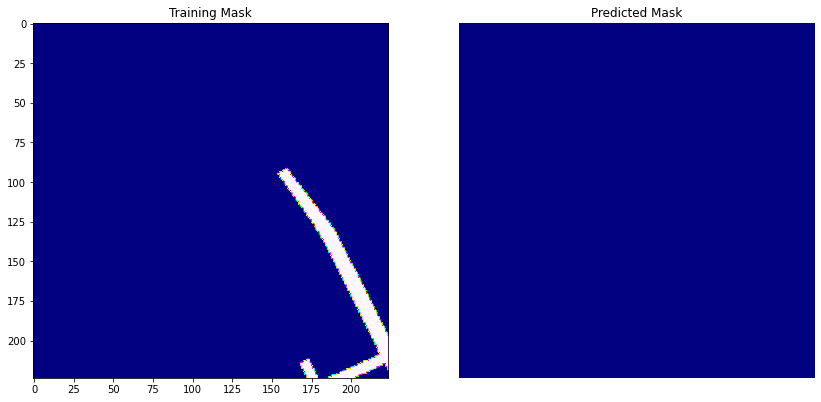

0.2364173 0.10123541
-5.9466556e-06 0.99999785
Jaccard: 0.7734962406015038


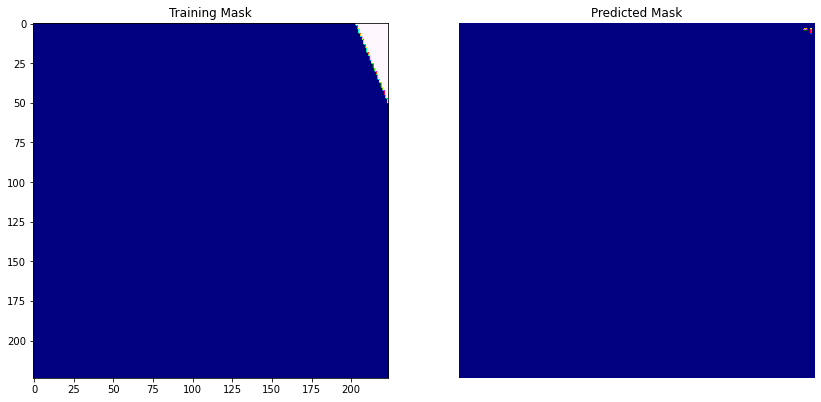

0.2364173 0.10123541
-5.9466556e-06 0.99999785
Jaccard: 0.8105214787930818


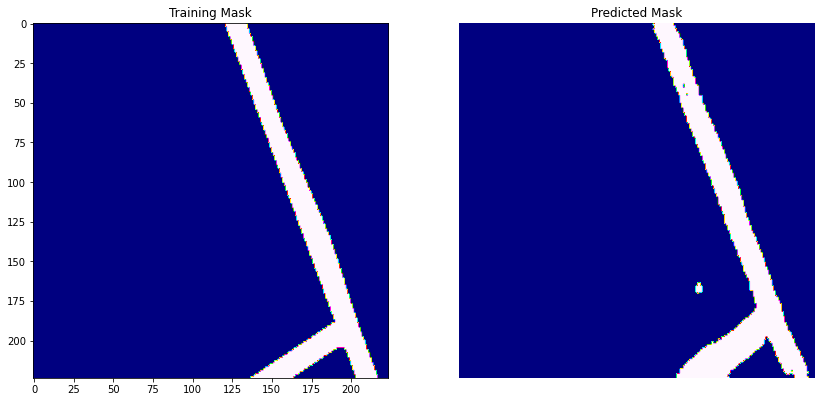

0.2364173 0.10123541
-5.9466556e-06 0.99999785
Jaccard: 0.9821428571428571


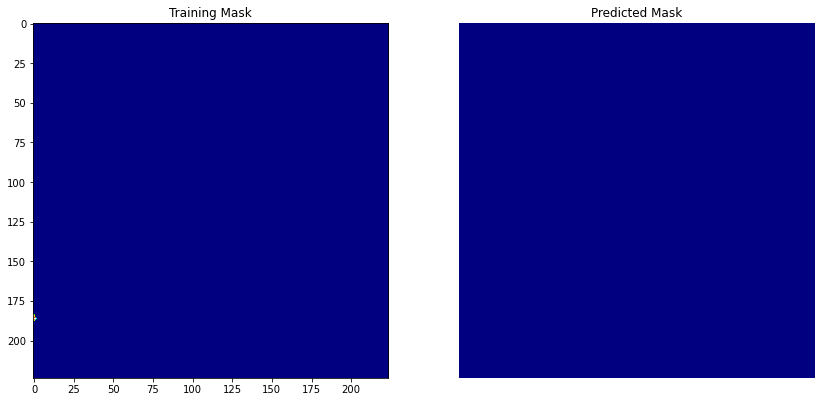

0.2364173 0.10123541
-5.9466556e-06 0.99999785
Jaccard: 0.5854352419724803


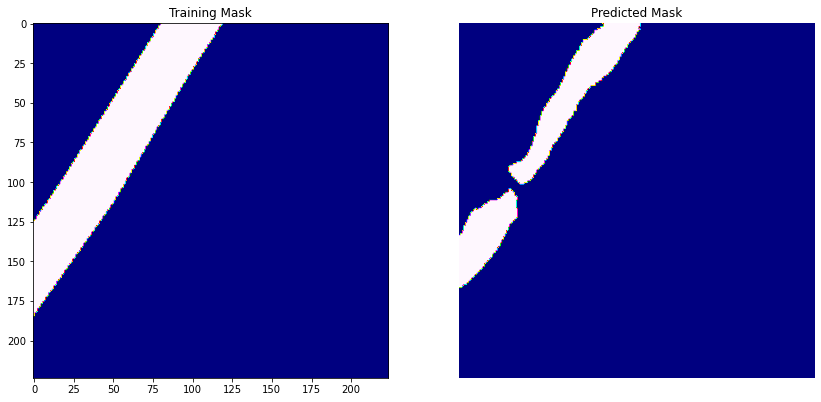

0.2364173 0.10123541
-5.9466556e-06 0.99999785
Jaccard: 0.8883928571428571


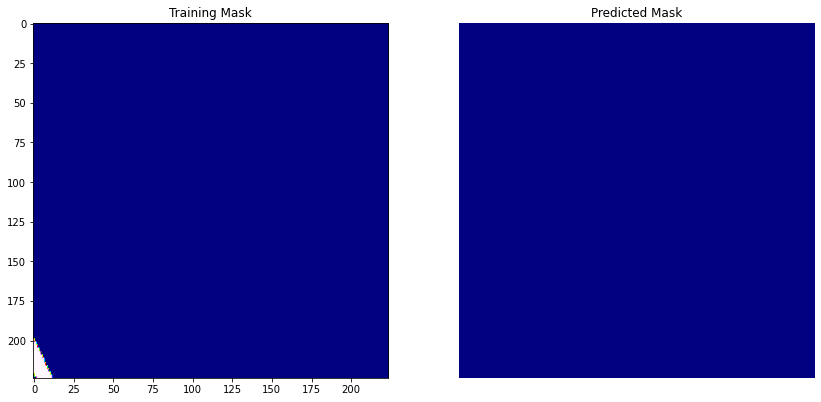

0.2364173 0.10123541
-5.9466556e-06 0.99999785
Jaccard: 0.5079879443551133


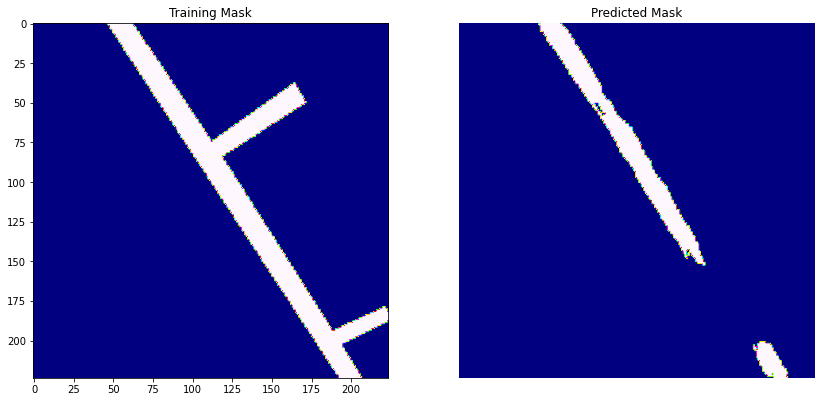

0.2364173 0.10123541
-5.9466556e-06 0.99999785
Jaccard: 0.9606230451096522


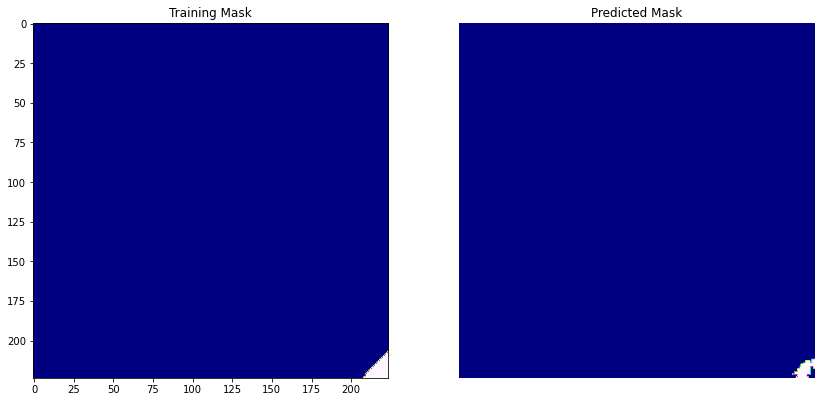

0.2364173 0.10123541
-5.9466556e-06 0.99999785
Jaccard: 0.9419642857142857


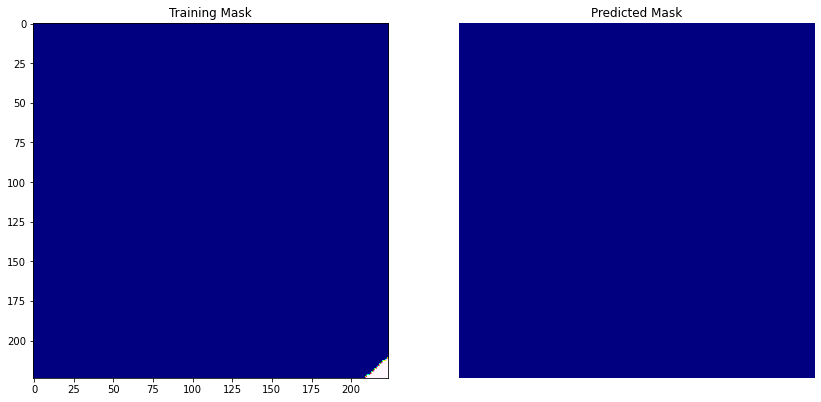

In [47]:
model = get_unet_5()  
model.load_weights('unet5_c1_99.hdf5')
import random
l = random.sample(range(1, 100), 10)
for i in l:
    check_predict_mask(model,0.5,i)